In [12]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [46]:
from cellgrid import CellGrid
from initialization import init_uniform
import numpy as np
from MDAnalysis.lib.pkdtree import PeriodicKDTree

In [47]:
# Benchmarking the algorithm
#######
# While capped_self_distance array takes care
# of creating a cellgrid object and then evaluating the 
# distances between points in relevant cells. The building 
# and creation of celllist with cellsize is benchmarked here.
import cellgrid 
def cg_build(box, maxdist, points):
    if box.shape == (6,):
        box1 = box[:3]
    else:
        box1 = box
    cg = CellGrid(box1,maxdist,points)
    return cg
###KDTree build
def kd_build(box,points):
    kdtree = PeriodicKDTree(box,bucket_size=10)
    kdtree.set_coords(points)
    return kdtree

In [48]:
Npoints = np.logspace(2,4,num=5,dtype=np.int32)
box = np.array([100,100,100,90,90,90],dtype=np.float32)
MaxDist = np.linspace(4,30,num=5,dtype=np.int32)

In [79]:
# Time and memory consumption to build cellgrid and KDtree
time_cg,mem_cg = [],[]
time_kd,mem_kd = [],[]
for npt in Npoints:
    points = init_uniform(box,npt)
    time = %timeit -q -o -n 1 -r 3 kd_build(box,points)
    mem = %memit -o -q kd_build(box,points)
    time_kd.append([npt,time.average,time.stdev])
    mem_kd.append([npt,mem.mem_usage[0]])
    for maxdist in MaxDist:
        time = %timeit -q -o -n 1 -r 3 cg_build(box,maxdist,points)
        mem = %memit -o -q cg_build(box,maxdist,points)
        time_cg.append([npt,maxdist,time.average,time.stdev])
        mem_cg.append([npt,maxdist,mem.mem_usage[0]])

In [36]:
import matplotlib
import matplotlib.pyplot as plt 

Text(0.5,1,'Build time')

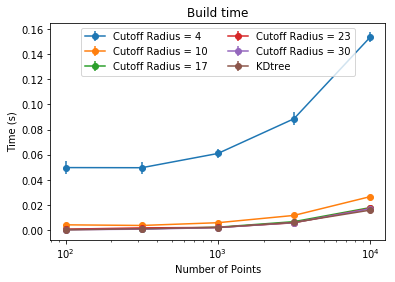

In [83]:
arr = np.array(time_cg)
for maxdist in MaxDist:
    mask = (arr[:,1]==maxdist)
    npt,avg,sd = (arr[mask,:][:,0]),(arr[mask,:][:,2]),(arr[mask,:][:,3])
    plt.errorbar(npt,avg,yerr=sd,label='Cutoff Radius = {}'.format(maxdist),fmt='-o')
    
plt.errorbar(npt,np.array(time_kd)[:,1],yerr=np.array(time_kd)[:,2],label='KDtree',fmt='-o')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=2, fancybox=True)
plt.xlabel('Number of Points')
plt.ylabel('Time (s)')
plt.xscale('log')
plt.title('Build time')

In [55]:
np.array(time_kd)[:,1]

array([0.019966  , 0.00086833, 0.00295433, 0.00563   , 0.01973733])

Text(0.5,1,'Memory Consumption')

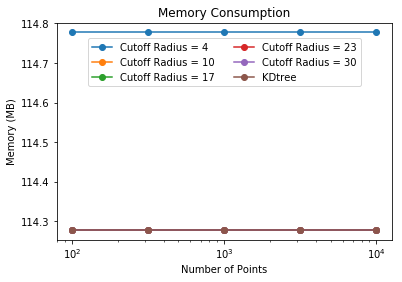

In [84]:
arr = np.array(mem_cg)
for maxdist in MaxDist:
    mask = (arr[:,1]==maxdist)
    npt,avg = (arr[mask,:][:,0]),(arr[mask,:][:,2])
    plt.errorbar(npt,avg,label='Cutoff Radius = {}'.format(maxdist),fmt='-o')   
plt.errorbar(npt,np.array(mem_kd)[:,1],label='KDtree',fmt='-o')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.95),
          ncol=2, fancybox=True)
plt.xlabel('Number of Points')
plt.ylabel('Memory (MB)')
plt.xscale('log')
plt.title('Memory Consumption')